In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Loading the training and test datasets
train_data = pd.read_csv("/content/fraudTrain.csv")
test_data = pd.read_csv("/content/fraudTest.csv")

# Merging the training and test datasets
combined_data = pd.merge(train_data, test_data, how='outer')

# Displaying the descriptive statistics of the combined dataset
combined_data.describe()


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [ ]:
# Displaying the first few rows of the combined dataset
print("First few rows of the dataset:")
print(combined_data.head())

# Displaying descriptive statistics of the combined dataset
print("\nDescriptive statistics:")
print(combined_data.describe())

# Checking for missing values in the dataset
print("\nMissing values count in each column:")
print(combined_data.isnull().sum())


First few rows of the dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize a dictionary to store label encoders
label_encoders = {}

# Columns to encode
label_encode_cols = ['merchant', 'category', 'gender', 'state', 'job']

# Apply LabelEncoder to specified columns in the dataset
for col in label_encode_cols:
    le = LabelEncoder()

    # Fit and transform the data and store the encoder
    combined_data[col] = le.fit_transform(combined_data[col])
    label_encoders[col] = le

    # Apply the same transformation to train and test datasets
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])


In [ ]:
def preprocess_dates(df):
    """Convert date columns to datetime and extract date features."""
    # Convert columns to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    # Extract date features
    df['transaction_year'] = df['trans_date_trans_time'].dt.year
    df['transaction_month'] = df['trans_date_trans_time'].dt.month
    df['transaction_day'] = df['trans_date_trans_time'].dt.day
    df['transaction_hour'] = df['trans_date_trans_time'].dt.hour

    df['birth_year'] = df['dob'].dt.year
    df['birth_month'] = df['dob'].dt.month
    df['birth_day'] = df['dob'].dt.day

    # Drop original date columns
    df.drop(['trans_date_trans_time', 'dob'], axis=1, inplace=True)
    return df

# Apply preprocessing function to each dataset
data = preprocess_dates(combined_data)
train = preprocess_dates(train_data)
test = preprocess_dates(test_data)


In [ ]:
# Define the columns to drop
columns_to_drop = ['first', 'last', 'street', 'city', 'trans_num']

# Drop specified columns from each dataset
data = data.drop(columns=columns_to_drop)
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)


In [ ]:
print(data.head(0))
print(data.head())
print(data.describe())
print(data.isnull().sum())

Empty DataFrame
Columns: [Unnamed: 0, cc_num, merchant, category, amt, gender, state, zip, lat, long, city_pop, job, unix_time, merch_lat, merch_long, is_fraud, transaction_year, transaction_month, transaction_day, transaction_hour, birth_year, birth_month, birth_day]
Index: []

[0 rows x 23 columns]
   Unnamed: 0            cc_num  merchant  category     amt  gender  state  \
0           0  2703186189652095       514         8    4.97       0     27   
1           1      630423337322       241         4  107.23       0     47   
2           2    38859492057661       390         0  220.11       1     13   
3           3  3534093764340240       360         2   45.00       1     26   
4           4   375534208663984       297         9   41.96       1     45   

     zip      lat      long  ...  merch_lat  merch_long  is_fraud  \
0  28654  36.0788  -81.1781  ...  36.011293  -82.048315         0   
1  99160  48.8878 -118.2105  ...  49.159047 -118.186462         0   
2  83252  42.1808 -112

<ipython-input-9-81a4c7ba3b8e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')


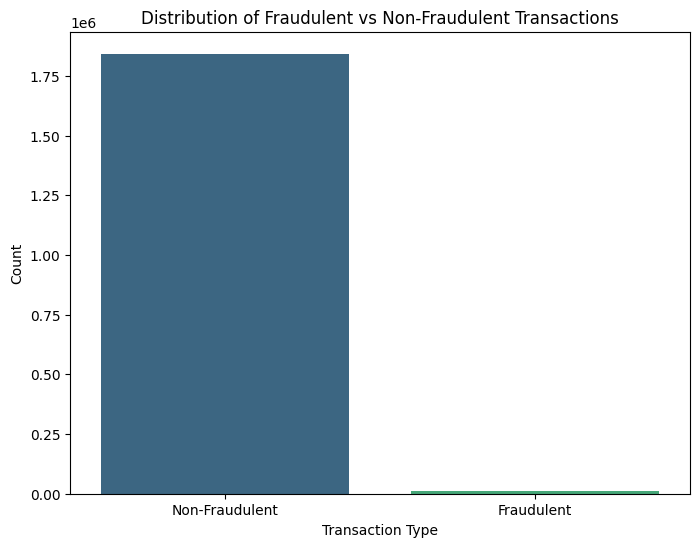

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of fraudulent vs non-fraudulent transactions
plt.figure(figsize=(8, 6))
fraud_counts = data['is_fraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()


In [ ]:
# Check for duplicated indices in the dataset
duplicate_indices_before = data.index.duplicated().sum()
print(duplicate_indices_before)

# Reset the index and drop the old index
data = data.reset_index(drop=True)

# Check for duplicated indices again
duplicate_indices_after = data.index.duplicated().sum()
print(duplicate_indices_after)


0
0


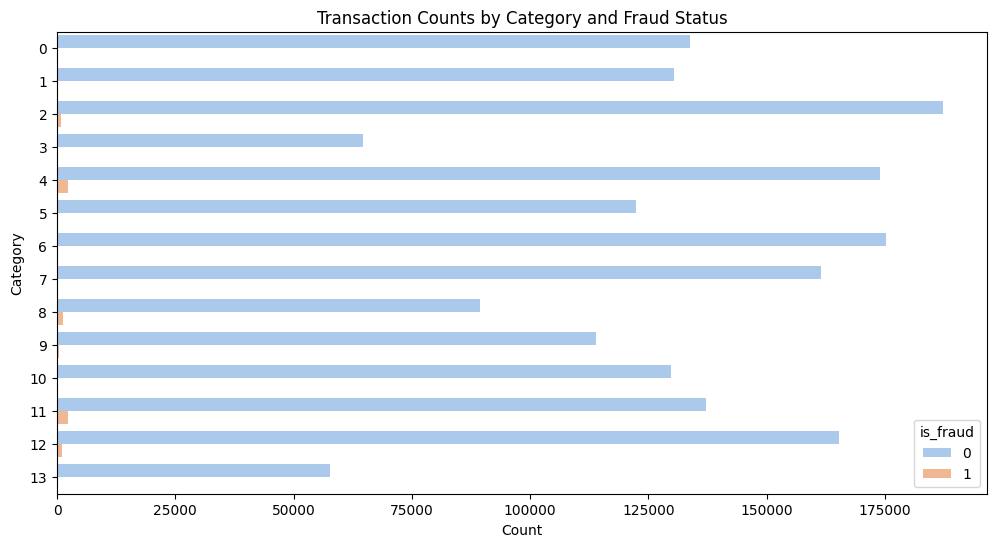

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot transaction counts by category and fraud status
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=data, y='category', hue='is_fraud', palette='pastel')
plt.title('Transaction Counts by Category and Fraud Status')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


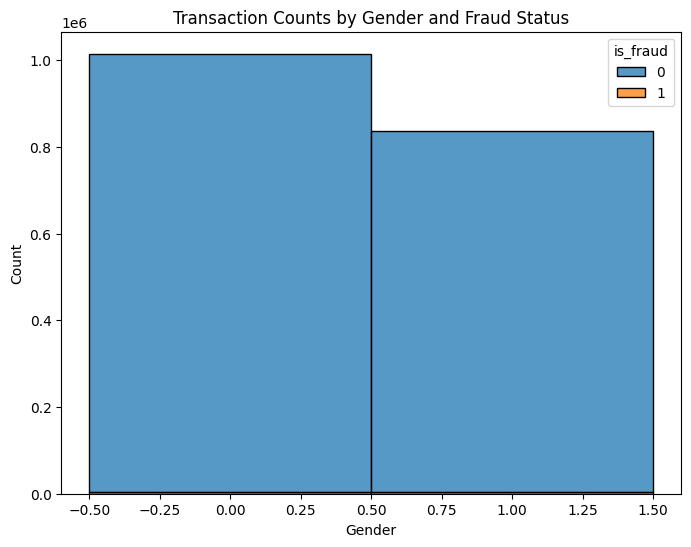

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot transaction counts by gender and fraud status
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='gender', hue='is_fraud', multiple='stack', discrete=True)
plt.title('Transaction Counts by Gender and Fraud Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


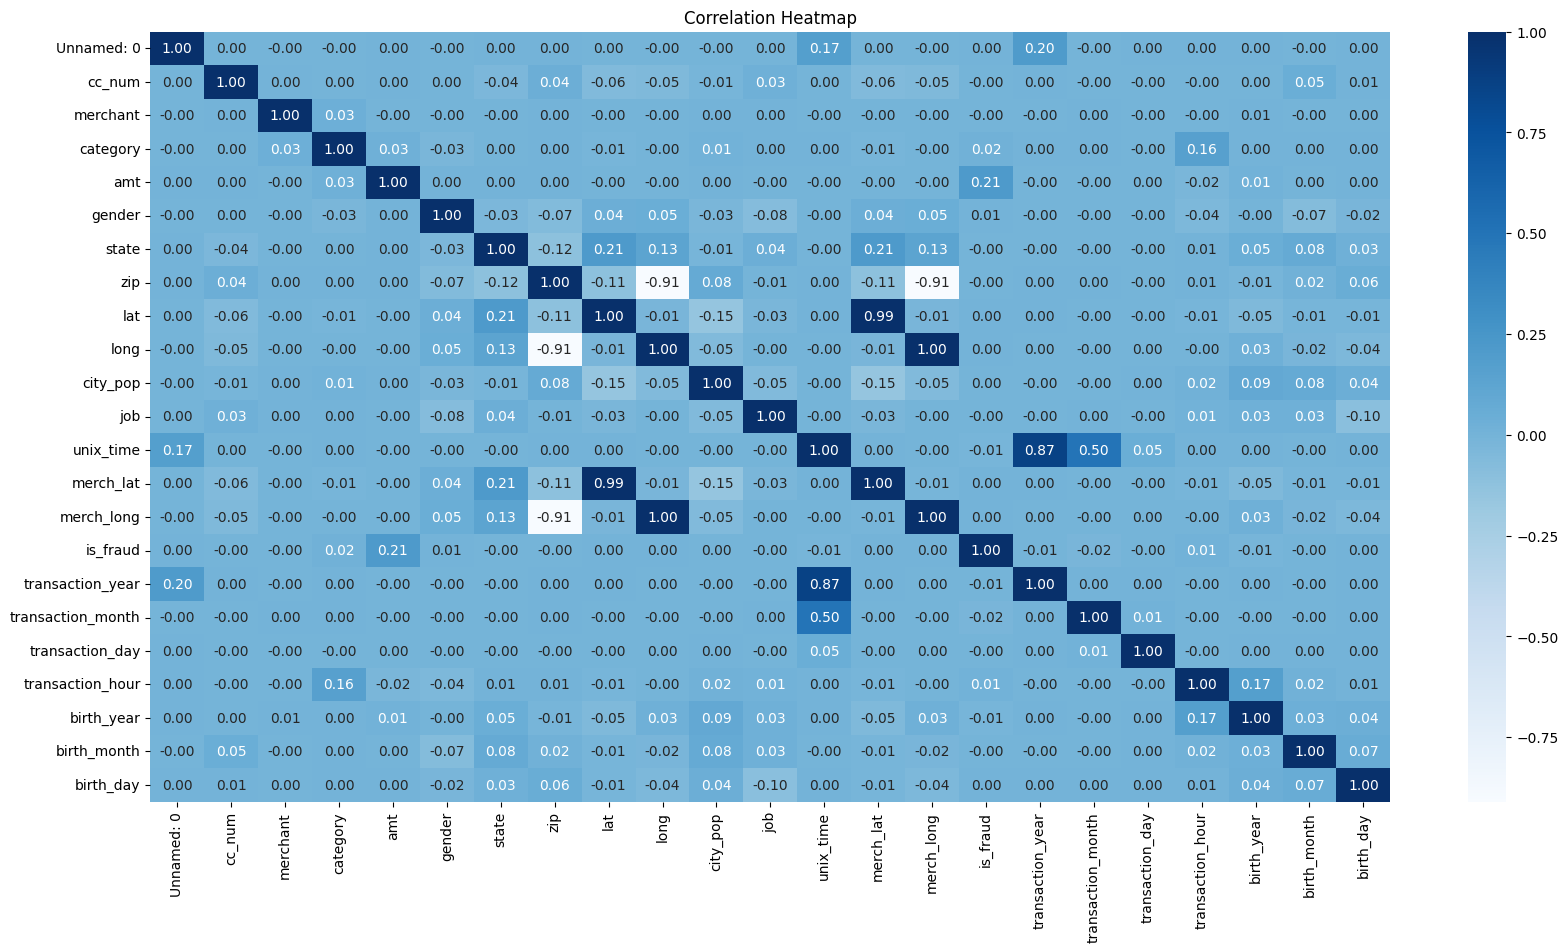

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Instantiate and train the Decision Tree model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Predict on the test set
predictions_tree = decision_tree.predict(X_test)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, predictions_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions_tree))
print("Accuracy Score:", accuracy_score(y_test, predictions_tree))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.80      0.84      0.82      1953

    accuracy                           1.00    370479
   macro avg       0.90      0.92      0.91    370479
weighted avg       1.00      1.00      1.00    370479

Confusion Matrix:
 [[368121    405]
 [   315   1638]]
Accuracy Score: 0.9980565700080166


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

# Make predictions on the test set
predictions = logistic_regression.predict(X_test)

# Evaluate and print the performance metrics
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Accuracy Score:", accuracy_score(y_test, predictions))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    368526
           1       0.00      0.00      0.00      1953

    accuracy                           0.99    370479
   macro avg       0.50      0.50      0.50    370479
weighted avg       0.99      0.99      0.99    370479

Confusion Matrix:
 [[368526      0]
 [  1953      0]]
Accuracy Score: 0.9947284461467452
